# Producing the main figure for the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [174]:
gaia_mc0 = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars. The hot limit is usually 5000 and the cool usually 3500
mint, maxt = 3500, 5000
m &= (gaia_mc1.color_teffs.values < maxt) * (mint < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc1.iloc[m]

(29727, 155)
(10544, 155) no visual binaries or subgiants
(10405, 155) no large vb uncertainties
(10274, 155) no faint stars
(9684, 155) no rapid rotators
(6820, 155) no hot or cold stars


Make cuts in log age.

In [175]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

Set up color values.

In [176]:
cmap = plt.cm.get_cmap('viridis_r')
vmin, vmax = np.log10(1e9*min(mid_age_bins)), np.log10(1e9*max(mid_age_bins))
log_agebins = np.log10(age_bins*1e9)
age_midbin = np.diff(log_agebins)*.5 + log_agebins[:-1]
color_values = (age_midbin - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format data.

In [177]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100
xlim = (maxt + 100, mint - 200)

tbins = np.linspace(min(x), max(x), 10)
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

In [178]:
def betterstep_scatter(bins, y, c, label, **kwargs):
    new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
    new_y = [a for row in zip(y, y) for a in row]
    ax = kwargs.pop("ax", plt.gca())
    ax.plot(new_x, new_y, color=c, lw=2, rasterized=True, label=label)

Make main figure

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

niter =  3 7 stars removed kurtosis =  0.16494527576110318
niter =  2 3 stars removed kurtosis =  -0.3206058375939782
niter =  2 5 stars removed kurtosis =  -0.44023564009195715
niter =  2 4 stars removed kurtosis =  -0.03953171441661585
niter =  3 13 stars removed kurtosis =  0.11288262025288498
niter =  3 14 stars removed kurtosis =  0.048021436188922184
niter =  3 7 stars removed kurtosis =  0.16494527576110318


  7%|▋         | 71/1000 [00:00<00:01, 709.91it/s]

niter =  2 3 stars removed kurtosis =  -0.3206058375939782


  8%|▊         | 76/1000 [00:00<00:01, 759.84it/s]

niter =  2 5 stars removed kurtosis =  -0.44023564009195715


  6%|▋         | 65/1000 [00:00<00:01, 645.85it/s]

niter =  2 4 stars removed kurtosis =  -0.03953171441661585


 13%|█▎        | 127/1000 [00:00<00:01, 634.09it/s]

niter =  3 13 stars removed kurtosis =  0.11288262025288498


 12%|█▎        | 125/1000 [00:00<00:01, 610.95it/s]

niter =  3 14 stars removed kurtosis =  0.048021436188922184


100%|██████████| 1000/1000 [00:01<00:00, 671.20it/s]


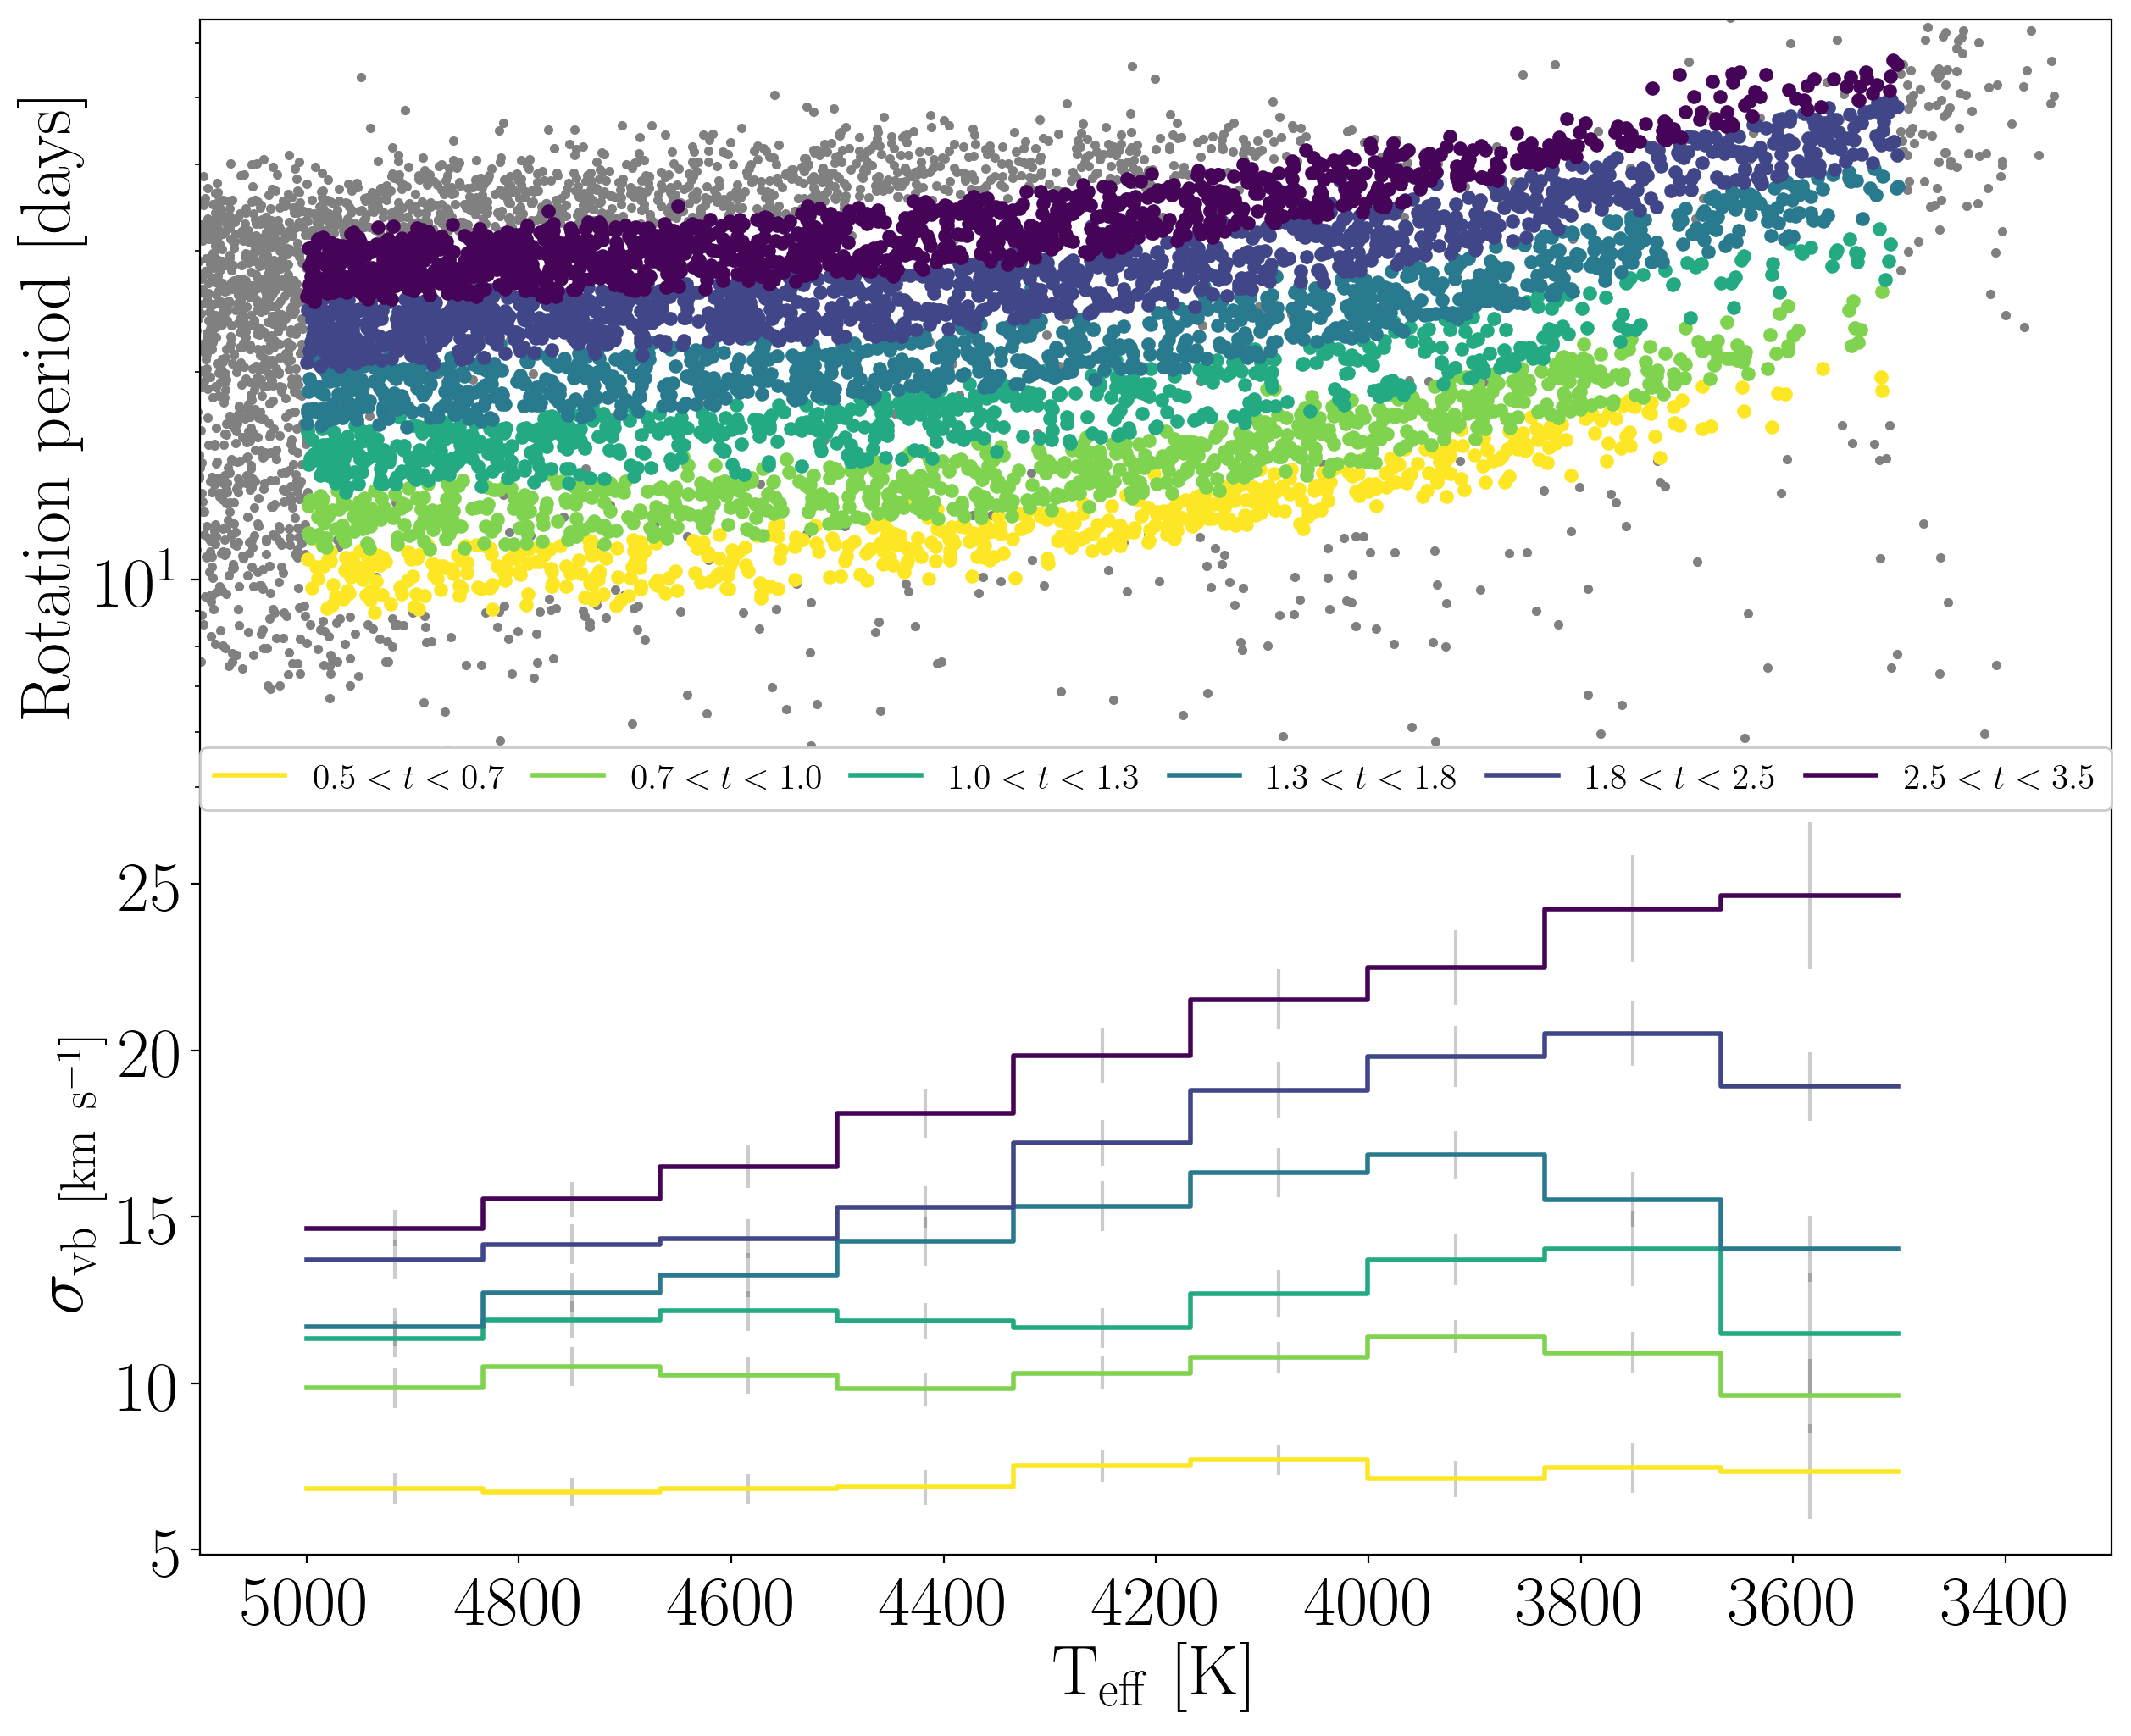

In [179]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter.
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Top panel: period-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    
# Add the sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(5, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr
    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < t < {1:.1f}$".format(age_bins[i], age_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.2,
                 rasterized=True)
    
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb~[km~s^{-1}]}$")
ax2.set_xlim(xlim)
plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)

plt.subplots_adjust(hspace=0, right=0.83)
plt.savefig("paper/age_cut.pdf")

Now make cuts in rotation period.

In [180]:
period_bins = 10**np.linspace(np.log10(10), np.log10(50), 9)
mid_period_bins = period_bins[:-1] + .5*np.diff(period_bins)
period_masks = select_stars(gaia_mc, period_bins, "Prot")

pds, pderrs = [np.zeros((len(period_bins), len(tbins[:-1]))) for i in range(2)]

Set the color scale.

In [181]:
vmin, vmax = min(mid_period_bins), max(mid_period_bins)
color_values = (mid_period_bins - vmin)/(vmax - vmin)
rgba = cmap(color_values)

Format the data.

In [182]:
y = gaia_mc.Prot.values

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

niter =  4 6 stars removed kurtosis =  0.09552370124130105
niter =  3 4 stars removed kurtosis =  -0.19108232811151726
niter =  2 1 stars removed kurtosis =  -0.4101956686379151
niter =  3 9 stars removed kurtosis =  -0.21764924861995105
niter =  2 6 stars removed kurtosis =  -0.1311292348564579
niter =  2 4 stars removed kurtosis =  0.016602468943425208
niter =  3 5 stars removed kurtosis =  -0.0783892964213897
niter =  3 4 stars removed kurtosis =  0.033785787330564254
niter =  4 6 stars removed kurtosis =  0.09552370124130105


  8%|▊         | 79/1000 [00:00<00:01, 781.47it/s]

niter =  3 4 stars removed kurtosis =  -0.19108232811151726


  8%|▊         | 75/1000 [00:00<00:01, 742.11it/s]

niter =  2 1 stars removed kurtosis =  -0.4101956686379151


 15%|█▌        | 150/1000 [00:00<00:01, 739.84it/s]

niter =  3 9 stars removed kurtosis =  -0.21764924861995105


 14%|█▍        | 142/1000 [00:00<00:01, 701.13it/s]

niter =  2 6 stars removed kurtosis =  -0.1311292348564579


  7%|▋         | 66/1000 [00:00<00:01, 659.00it/s]

niter =  2 4 stars removed kurtosis =  0.016602468943425208


  7%|▋         | 71/1000 [00:00<00:01, 709.71it/s]

niter =  3 5 stars removed kurtosis =  -0.0783892964213897


  8%|▊         | 83/1000 [00:00<00:01, 823.57it/s]

niter =  3 4 stars removed kurtosis =  0.033785787330564254


100%|██████████| 1000/1000 [00:01<00:00, 838.64it/s]


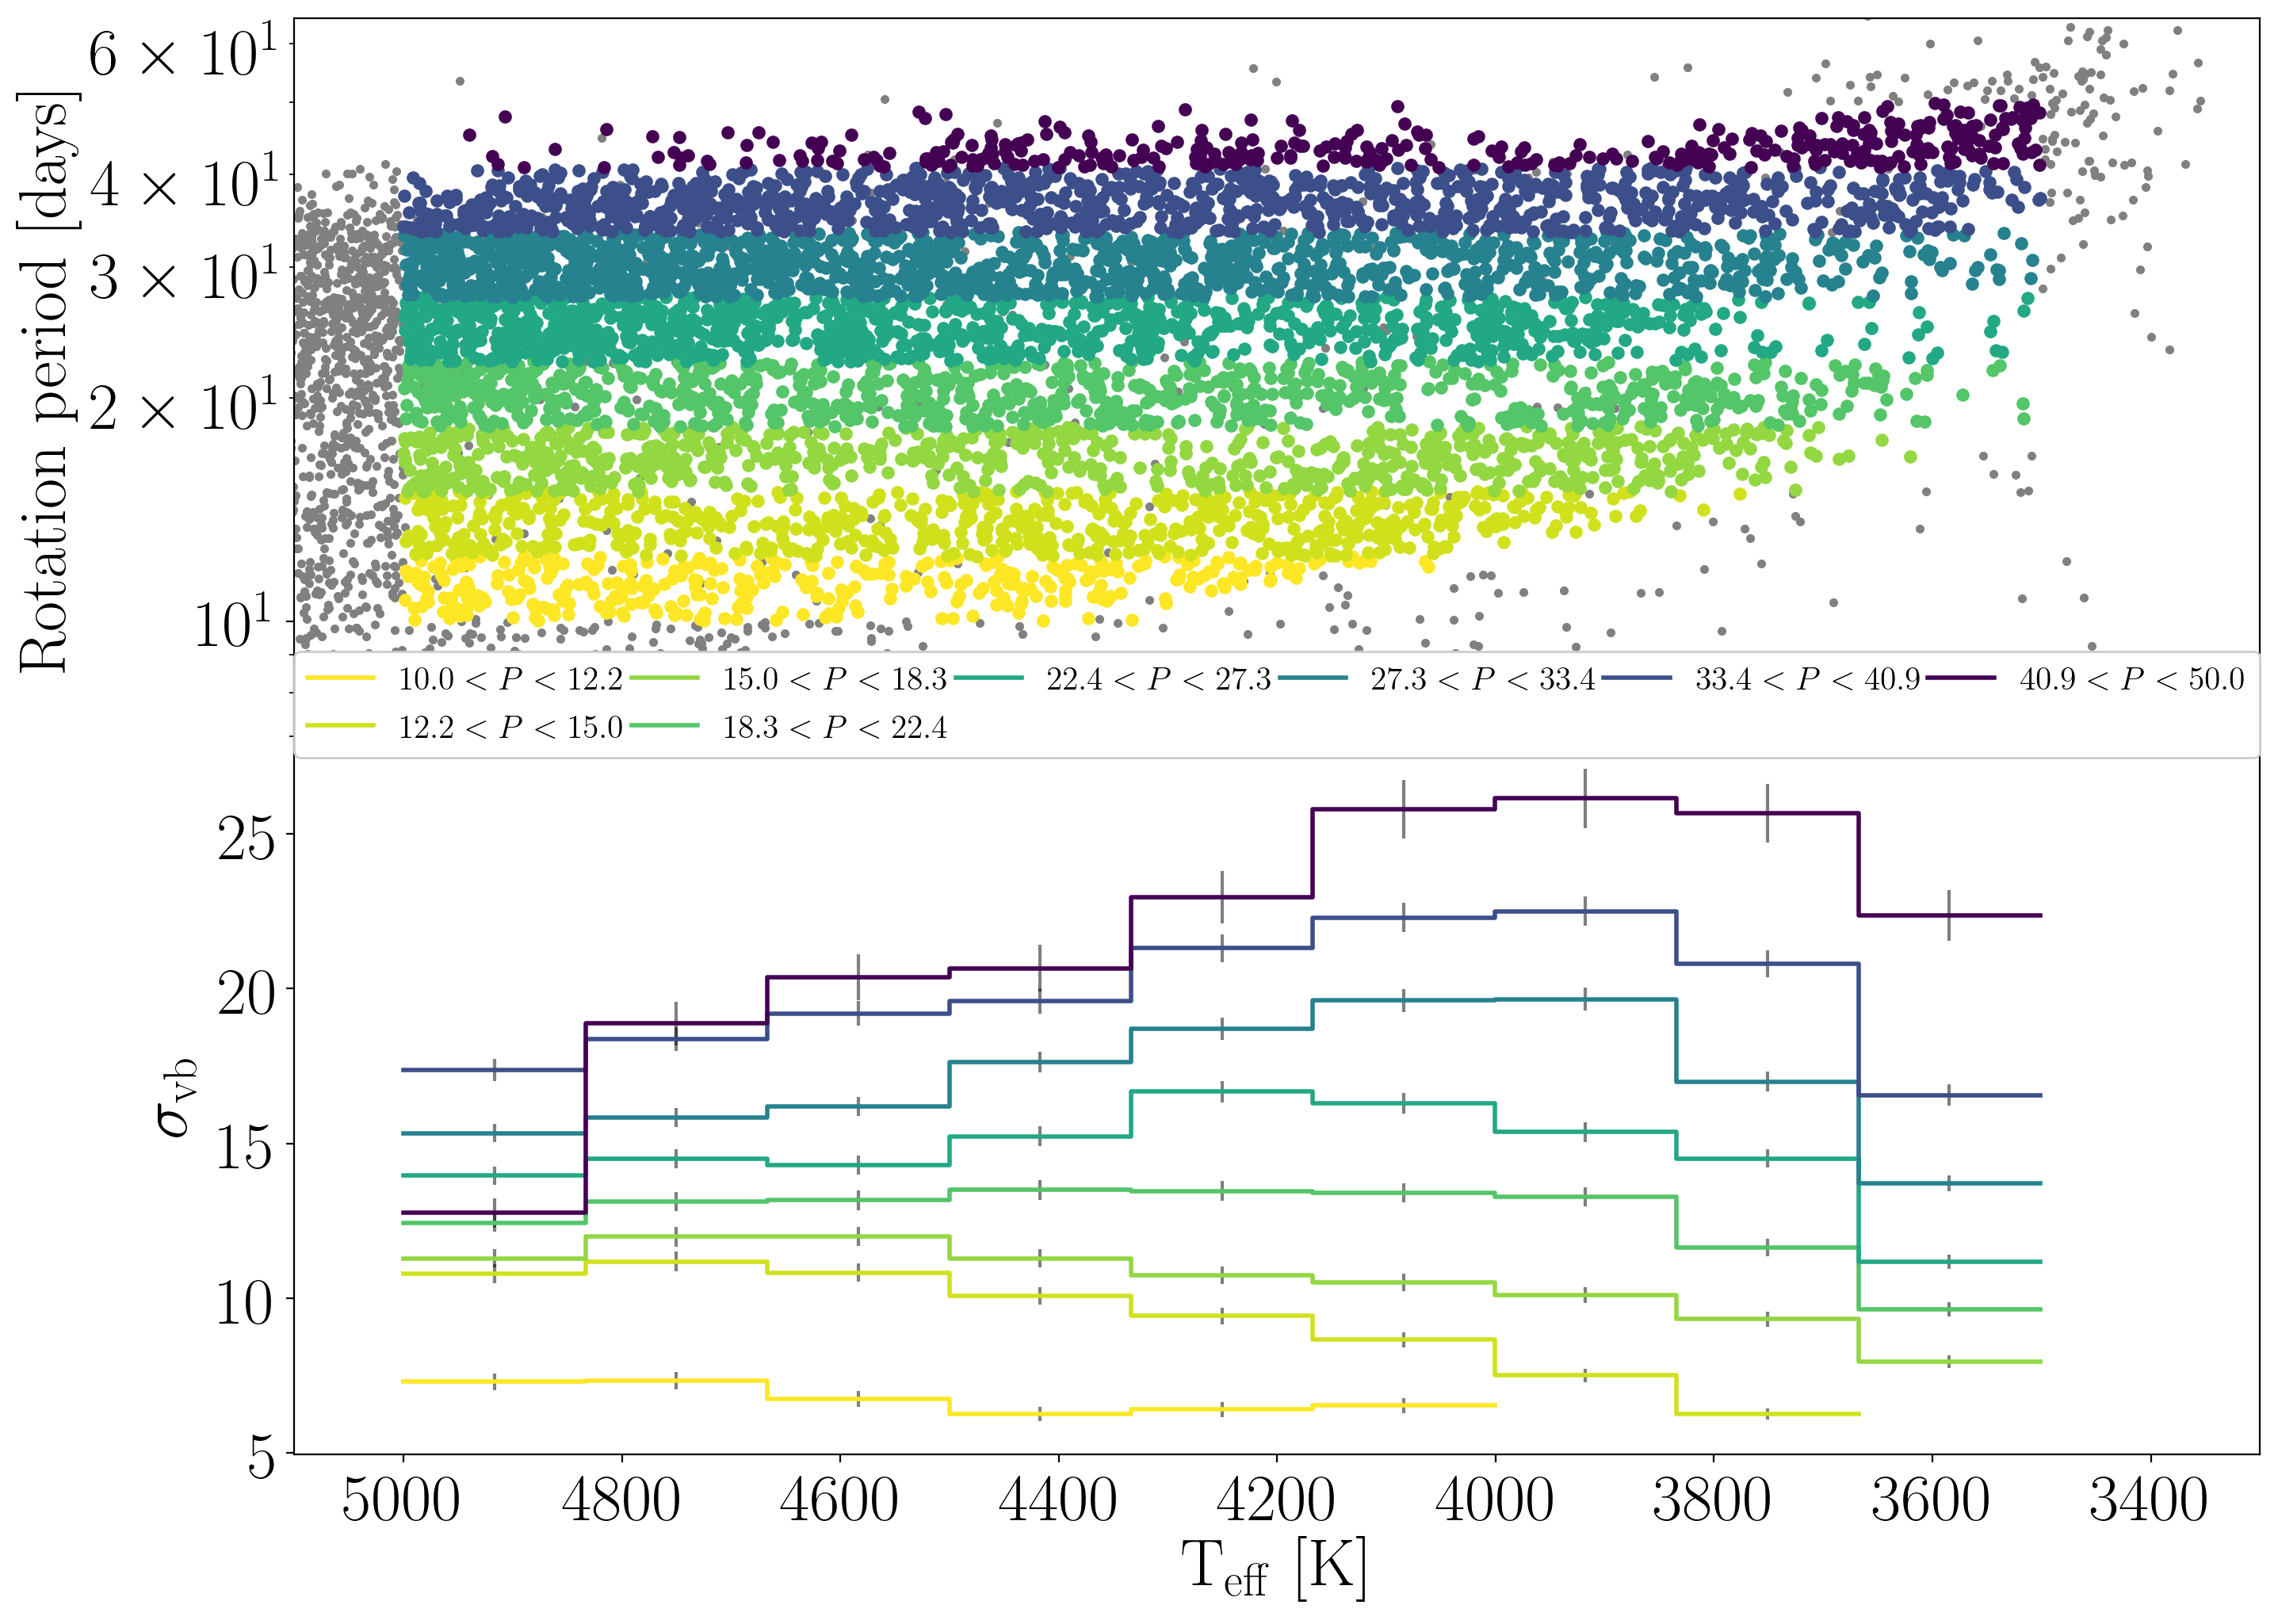

In [183]:
fig = plt.figure(figsize=(16, 12), dpi=200)

ax1 = fig.add_subplot(211)

# Background scatter
ax1.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# Colored sections in period-color space
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    cb1 = ax1.scatter(x[m][clipping_mask], y[m][clipping_mask], c=rgba[i],
                      vmin=vmin, vmax=vmax, rasterized=True, zorder=1, s=25,
                      label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    
# Sun
ax1.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
ax1.plot(5778, 26, "k.", zorder=3, rasterized=True)
    
ax1.set_ylim(7, 65)
ax1.set_ylabel("$\mathrm{Rotation~period~[days]}$")
ax1.set_yscale("log")
plt.setp(ax1.get_xticklabels(), visible=False)

# Velocity-teff plot
ax2 = fig.add_subplot(212, sharex=ax1)

# Bottom panel: velocity dispersion-teff relations
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped,
                                     xerr[m][clipping_mask], verr[m][clipping_mask],
                            tbins, 1000, method="std")
    derr = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
    pds[i, :] = d
    pderrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))

    midbin = np.diff(tbins)*.5+tbins[:-1]
    cb2 = betterstep_scatter(tbins, d, rgba[i],
                             label="${0:.1f} < P < {1:.1f}$".format(period_bins[i], period_bins[i+1]))
    ax2.errorbar(midbin, d, yerr=derr, fmt=".", zorder=0, ms=.01, color="k", alpha=.5,
                 rasterized=True)

plt.legend(bbox_to_anchor=(0., .97, 1., .102), loc=3, ncol=6, mode="expand", borderaxespad=0., framealpha=.999)
ax2.set_xlabel("$\mathrm{T_{eff}~[K]}$")
ax2.set_ylabel("$\sigma_\mathrm{vb}$")
ax2.set_xlim(xlim)
plt.subplots_adjust(hspace=0)  # , right=0.83)
plt.savefig("paper/period_cut.pdf")

In [172]:
vmin, vmax = np.min(ds[ds > 0]), np.max(ds)
color_values = (ds - vmin)/(vmax - vmin)
rgba = cmap(color_values)

pvmin, pvmax = np.min(pds[pds > 0]), np.max(pds[np.isfinite(pds)])
pcolor_values = (pds - pvmin)/(pvmax - pvmin)
prgba = cmap(pcolor_values)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


niter =  4 6 stars removed kurtosis =  0.09552370124130105
niter =  3 3 stars removed kurtosis =  -0.2553398418540831
niter =  2 1 stars removed kurtosis =  -0.4689598263274024
niter =  3 6 stars removed kurtosis =  -0.20556112154060502
niter =  2 5 stars removed kurtosis =  -0.11419259128480785
niter =  3 3 stars removed kurtosis =  0.004951247919434465
niter =  2 2 stars removed kurtosis =  -0.16051510976920236
niter =  1 0 stars removed kurtosis =  -0.18223850829243338


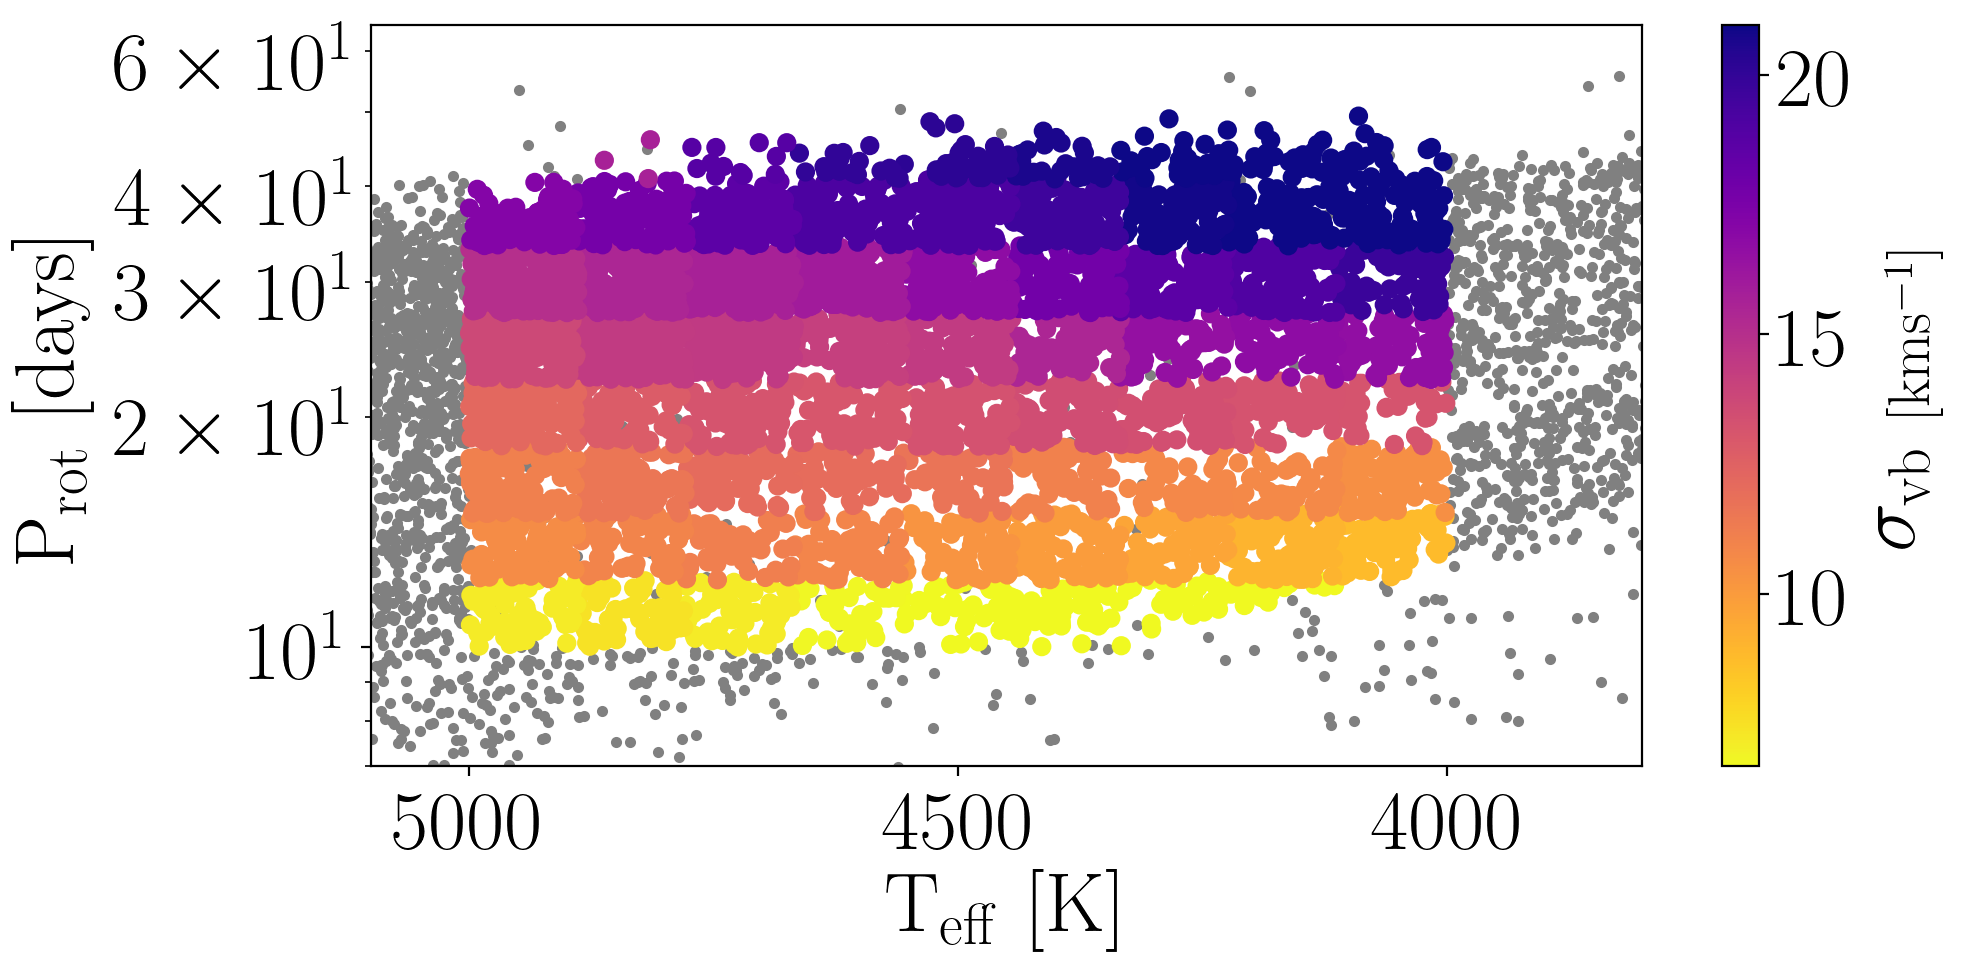

In [173]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(gaia_mc1.color_teffs, gaia_mc1.Prot, ".", color=".5", rasterized=True, zorder=0)

# for i, m in enumerate(age_masks):
for i, m in enumerate(period_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    
    for j in range(len(tbins)-1):
        tm = (x[m][clipping_mask] > tbins[j]) * (x[m][clipping_mask] < tbins[j+1])
        cb1 = plt.scatter(x[m][clipping_mask][tm], y[m][clipping_mask][tm],
                          c=np.ones_like(y[m][clipping_mask][tm])*pds[i, j],
                          vmin=vmin, vmax=vmax,
                          rasterized=True, zorder=1, s=35, cmap="plasma_r")

plt.colorbar(cb1, label="$\sigma_\mathrm{vb~[kms^{-1}]}$")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.xlim(xlim)
plt.yscale("log")
plt.ylim(7, 65)
plt.tight_layout()
# plt.savefig("paper/dispersion_period_teff.pdf")